In [4]:
import matplotlib.pyplot as plt
import numpy as np
import sys, pathlib

# Project-1 folder (parent of this Notebooks/ folder)
proj_dir = pathlib.Path.cwd().parent
if str(proj_dir) not in sys.path:
    sys.path.insert(0, str(proj_dir))

# Figures folder
fig_dir = proj_dir / "Figures"
fig_dir.mkdir(parents=True, exist_ok=True)

from Code.data import make_data, build_features, split_and_scale

# --- Project-wide experiment config (used in ALL notebooks) ---

# Data settings
N_SAMPLES   = 300     # number of samples
NOISE_SD    = 0.3     # noise standard deviation
SEED_DATA   = 42      # data generation
SEED_SPLIT  = 42      # train/test split (split_and_scale uses this)
DEG_MAX     = 15      # max polynomial degree for features
P_FIXED     = 15      # fixed polynomial degree for regularization experiments
TEST_SIZE   = 0.20    # train/test split size


# Regularization grids
LAM_GRID_RIDGE = np.logspace(-6, 1, 40)  # wider range for ridge
LAM_GRID_LASSO = np.logspace(-6, 0, 60)  # less range for LASSO

# Optimizer settings
ETA_FULL   = 5e-3     # full-batch GD steps, fixed
ITERS_FULL = 5000     # full-batch GD iterations
LAM_RIDGE  = 0.0203   # Taken from ridge experiments (02_Ridge_lambda.ipynb) best lambda for degree 15
LAMBDAS    = np.r_[0.0, np.logspace(-6, 5, 40)]
# Mini-batch SGD
EPOCHS_MB    = 25     # passes over data
BATCH_SIZE   = 64     # minibatch size
ETA_MB_OLS   = 1e-2   # for OLS, can be larger
ETA_MB_RIDGE = 1e-2   # for ridge, need to tune
SEED_MB      = 42     # minibatch shuffle

# --- Generate data explicitly---
x, y = make_data(n=N_SAMPLES, noise_sd=NOISE_SD, seed=SEED_DATA)
X_full = build_features(x, degree=DEG_MAX, include_bias=False)


X_tr_s, X_te_s, y_tr_c, y_te, scaler, y_mean = split_and_scale(X_full, y, test_size=TEST_SIZE, random_state=SEED_SPLIT)

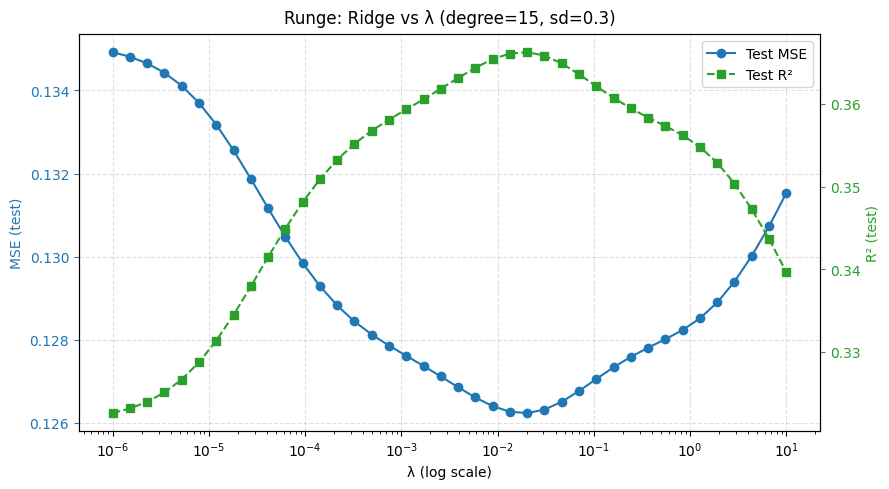

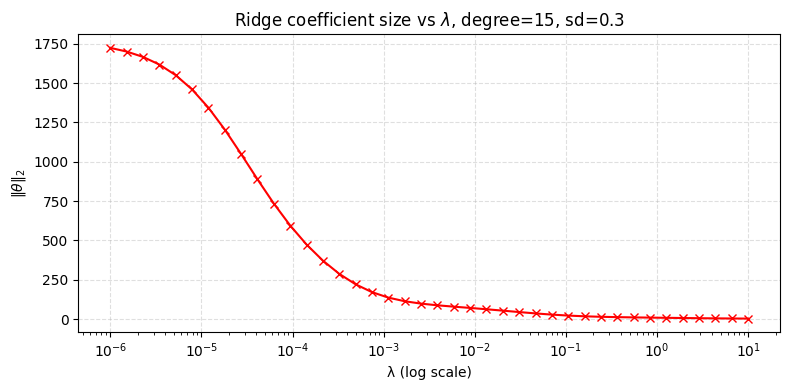

In [5]:
# --- Part (b): Ridge regularization ---

from Code.models import sweep_ridge
from Code.plots import plot_ridge_curves, plot_theta_norms

# Ridge vs lambda (fixed degree)

mse_r, r2_r, norms_r = sweep_ridge(
    X_full, y, split_func=split_and_scale,
    degree=P_FIXED, lambdas=LAM_GRID_RIDGE, n_factor=True
)

# plots for (b)
# plot MSE and R2 vs lambda:
plot_ridge_curves(LAM_GRID_RIDGE, mse_r, r2_r, title=f"Runge: Ridge vs λ (degree={P_FIXED}, sd=0.3)", savepath=fig_dir / "runge_ridge_mse_r2_vs_lambda.png")

# plot Ridge coefficient norms vs lambda:
plot_theta_norms(LAM_GRID_RIDGE, norms_r,
                 xlabel="λ (log scale)",
                 title=r"Ridge coefficient size vs $\lambda$, degree=15, sd=0.3",
                 savepath=fig_dir / "ridge_theta_norms_vs_lambda.png",
                 logx=True)

In [12]:
lam_grid = np.asarray(LAM_GRID_RIDGE)
mse_r    = np.asarray(mse_r)
r2_r     = np.asarray(r2_r)

i_mse = int(np.nanargmin(mse_r))
i_r2  = int(np.nanargmax(r2_r))

print(f"[Ridge best by MSE]  degree={P_FIXED}  λ={lam_grid[i_mse]:.3g}   "
      f"MSE={mse_r[i_mse]:.6f}  R²={r2_r[i_mse]:.4f}")

print(f"[Ridge best by R² ]  degree={P_FIXED}  λ={lam_grid[i_r2]:.3g}   "
      f"MSE={mse_r[i_r2]:.6f}  R²={r2_r[i_r2]:.4f}")

# Compare against OLS (λ=0)
print(f"[OLS (λ=0)]           degree={P_FIXED}  λ=0                    "
      f"MSE={mse_ols:.6f}     R²={r2_ols:.4f}")

if mse_ols <= mse_r[i_mse]:
    print("=> On this split, OLS (λ=0) beats or ties the best Ridge λ by MSE.")
else:
    print("=> On this split, a positive Ridge λ improves on OLS by MSE.")

[Ridge best by MSE]  degree=15  λ=0.0203   MSE=0.126234  R²=0.3662
[Ridge best by R² ]  degree=15  λ=0.0203   MSE=0.126234  R²=0.3662
[OLS (λ=0)]           degree=15  λ=0                    MSE=0.135149     R²=0.3215
=> On this split, a positive Ridge λ improves on OLS by MSE.
